# Multisite Production Planning Problem

The main aim of the notebook is to implement multisite production planning problem using serial optimization approach.

## Configure the environment 

In [1]:
# You may need to uncomment the following command to install the necessary third-party packages the first time you run this notebook.
# !pip install PuLP matplotlib tqdm

### Import required libraries

In [1]:
import getpass
import time
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pulp as plp
import os
import sys
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

### Optimization Class

In [2]:
class ProductionPlanning:
    """
    A class for managing production planning optimization.
    """

    def __init__(self):
        """
        Initializes ProductionPlanning object with necessary attributes.
        """
        self.prob = None
        self.solver_log = None
        self.__product_ids = set()
        self.__machine_ids = set()
        self.__product_raw_materials = dict()
        self.__product_raw_materials_cost = dict()
        self.__product_min_market_demand = dict()
        self.__product_max_market_demand = dict()
        self.__product_machine_labor_time_min = dict()
        self.__machine_available_time_hour = dict()
        self.__machine_cost_hour = dict()
        self.__product_price = dict()
        self.__raw_material_inventory = None

    def prepare_input_data(self, in_df: pd.DataFrame):
        """
        Prepares input data for optimization.

        Parameters:
        - in_df: DataFrame containing input data.
        """
        # Extract product and machine IDs
        self.__product_ids = set(in_df['ProductID'])
        self.__machine_ids = set(in_df['MachineID'])

        # Create dictionaries for product and machine data
        product_df = in_df.drop_duplicates(subset=['ProductID'], keep='first', ignore_index=True)
        product_df.set_index(keys=['ProductID'], inplace=True)
        product_dict = product_df.to_dict(orient='dict')

        # Fill product-related dictionaries
        self.__product_raw_materials = product_dict['RawMaterialPerProduct']
        self.__product_raw_materials_cost = product_dict['RawMaterialCost']
        self.__product_min_market_demand = product_dict['MinimumMarketDemandPerProduct']
        self.__product_max_market_demand = product_dict['MaximumMarketDemandPerProduct']
        self.__product_price = product_dict['ProductPrice']

        product_machine_df = in_df.drop_duplicates(subset=['ProductID', 'MachineID'], keep='first', ignore_index=True)
        product_machine_df.set_index(keys=['ProductID', 'MachineID'], inplace=True)
        product_machine_dic = product_machine_df.to_dict(orient='dict')

        # Fill product-machine labor time dictionary
        self.__product_machine_labor_time_min = product_machine_dic['ProductMachineLaborTimeInMin']

        machine_df = in_df.drop_duplicates(subset=['MachineID'], keep='first', ignore_index=True)
        machine_df.set_index(keys=['MachineID'], inplace=True)
        machine_dic = machine_df.to_dict(orient='dict')

        # Fill machine-related dictionaries
        self.__machine_available_time_hour = machine_dic['MachineWeeklyAvailableTimeInHour']
        self.__machine_cost_hour = machine_dic['MachineCostPerHour']

        # Set raw material inventory
        self.__raw_material_inventory = in_df['RawMaterialInventory'].unique()[0]

    def setup_optimization_problem(self, problem_name: str, optimization_type: str, variable_prefix: str = "x",
                                   write_model_file: bool = False, model_file_path: str = None,
                                   model_file_name: str = None):
        """
        Sets up the optimization problem.

        Parameters:
        - problem_name: Name of the optimization problem.
        - optimization_type: Type of optimization (Minimization or Maximization).
        - variable_prefix: Prefix for decision variables.
        - write_model_file: Whether to write the model to a file.
        - model_file_path: Path to the directory for model files.
        - model_file_name: Name of the model file.
        """
        # Set optimization sense
        if optimization_type == "Minimization":
            sense = plp.LpMinimize
        elif optimization_type == "Maximization":
            sense = plp.LpMaximize
        else:
            sense = None

        prob = plp.LpProblem(name=problem_name, sense=sense)

        # Setup decision variables
        product_ids = self.__product_ids
        production_vars = plp.LpVariable.dicts(name=variable_prefix, indices=product_ids, lowBound=0,
                                               upBound=None, cat='Integer')

        # Setup Objective Function
        # Profit = Revenue - Raw Material Cost - Production Cost
        prob += (
            plp.lpSum([(self.__product_price[i] * production_vars[i]) for i in product_ids])  # Revenue
            - plp.lpSum([(self.__product_raw_materials[i] * self.__product_raw_materials_cost[i] * production_vars[i])
                         for i in product_ids])  # Raw Material Cost
            - plp.lpSum([((self.__product_machine_labor_time_min[i, j] / 60.0) * self.__machine_cost_hour[j] * production_vars[i])
                         for i in product_ids for j in self.__machine_ids]),  # Production Cost
            "Total Production Profit"
        )

        # Setup Constraints
        for product in product_ids:
            # Constraint: Production Volume <= Max Market Demand
            prob += (
                production_vars[product] <= self.__product_max_market_demand[product], f"Const_MaxMarketDemand_{product}"
            )
            # Constraint: Production Volume >=  Min Market Demand
            prob += (
                production_vars[product] >= self.__product_min_market_demand[product], f"Const_MinMarketDemand_{product}"
            )
            
        # Constraint: Machine Production Time <= Machine Available Time
        for machine in self.__machine_ids:
            prob += (
                plp.lpSum((self.__product_machine_labor_time_min[product, machine] / 60.0) * production_vars[product]
                          for product in product_ids) <= self.__machine_available_time_hour[machine],
                f"Const_MachineAvailableTime_{machine}"
            )
        
        # Constraint: required raw materials to produce products <= raw material inventory 
        prob += (
            plp.lpSum(self.__product_raw_materials[product] * production_vars[product] for product in product_ids)
            <= self.__raw_material_inventory, "Const_RawMaterialInventory"
        )

        # Write model file if requested
        if write_model_file and model_file_path is not None and model_file_name is not None:
            prob.writeLP(os.path.join(model_file_path, model_file_name))

        self.prob = prob

    def execute_optimization(self, enable_log: bool = False):
        """
        Executes the optimization process.

        Parameters:
        - enable_log: Whether to enable solver log.
        """
        if enable_log:
            plp.LpSolverDefault.msg = 1
        else:
            plp.LpSolverDefault.msg = 0
            
        self.prob.solve()

    def get_optimization_object(self):
        """
        Returns the optimization object.
        """
        return self.prob

## Connect to Database

In [3]:
database_name = "my_demo_db.db"

con = sqlite3.connect(database_name)

In [4]:
# Utility function
def execute_sql(con: sqlite3.Connection, sql: str):
    """
    Executes the given SQL command using the provided SQLite connection.

    Parameters:
    con (sqlite3.Connection): The SQLite connection object.
    sql (str): The SQL command to be executed.

    Returns:
    sqlite3.Cursor: The cursor object resulting from the executed SQL command.

    Raises:
    Exception: Re-raises any exceptions that occur during the execution of the SQL command.
    """
    try:
        # Use the connection context manager to ensure the command is executed and committed if successful
        with con:
            res = con.execute(sql)  # Execute the SQL command and store the resulting cursor
    except Exception as e:
        # Re-raise any exception that occurs during execution for further handling
        raise e
    
    return res  # Return the cursor resulting from the executed SQL command

## Optimize & Evaluate 

In [5]:
# Define paramaters
data_table_name = 'ProductPlanData'
results_table_name = "ProductPlanResults"

In [6]:
# Check existed tables in the database 
sql = f"""
SELECT name FROM sqlite_master WHERE type='table';
"""
existed_table_df = pd.read_sql_query(con=con, sql=sql)
existed_table_df

,name
0,ProductData
1,ProductMachineData
2,MachineData
3,InventoryData


In [7]:
# Create table to save the outcomes of the optimization process.
# Delete old results table if existed 
if results_table_name in existed_table_df.values:
    execute_sql(con=con, sql=f"DROP TABLE {results_table_name};")
    
# Then, create new table
sql = f"""
CREATE TABLE {results_table_name} ( 
ProductionSiteID VARCHAR(30),
OptimizationStatus  VARCHAR(30),
TotalBenefitPerProductionSite FLOAT,
ProductID  VARCHAR(30),
ProductionVolume INTEGER
);
"""
execute_sql(con=con, sql=sql)

In [8]:
# Create an intermediate table to retrieve input data 
sql = f"""
CREATE TEMPORARY TABLE {data_table_name} AS 
SELECT t1.ProductionSiteID, t1.ProductID, t1.RawMaterialPerProduct,
       t1.RawMaterialCost, t4.RawMaterialInventory, t1.MinimumMarketDemandPerProduct,
       t1.MaximumMarketDemandPerProduct, t2.MachineID, 
       t2.ProductMachineLaborTimeInMin, t3.MachineWeeklyAvailableTimeInHour,
       t3.MachineCostPerHour,t1.ProductPrice
       
FROM ProductData AS t1
INNER JOIN ProductMachineData t2
    ON t1.ProductionSiteID = t2.ProductionSiteID
    AND t1.ProductID = t2.ProductID
INNER JOIN MachineData t3
    ON t2.ProductionSiteID = t3.ProductionSiteID
    AND t2.MachineID = t3.MachineID
INNER JOIN InventoryData t4
    ON t1.ProductionSiteID = t4.ProductionSiteID
;
"""
execute_sql(con=con, sql=sql)

# check 
in_df = pd.read_sql(con=con, sql=f"SELECT * FROM {data_table_name};")
display(in_df.head(5))
display(f"Table shape: {in_df.shape}")

,ProductionSiteID,ProductID,RawMaterialPerProduct,RawMaterialCost,RawMaterialInventory,MinimumMarketDemandPerProduct,MaximumMarketDemandPerProduct,MachineID,ProductMachineLaborTimeInMin,MachineWeeklyAvailableTimeInHour,MachineCostPerHour,ProductPrice
0,S001,P_S001_A_01,13.0,10.0,11825.641052,1,20,Machine1,20.0,121.0,25.0,274.0
1,S001,P_S001_A_01,13.0,10.0,11825.641052,1,20,Machine2,16.0,104.0,32.0,274.0
2,S001,P_S001_A_01,13.0,10.0,11825.641052,1,20,Machine3,15.0,82.0,45.0,274.0
3,S001,P_S001_A_02,11.0,10.0,11825.641052,0,20,Machine1,24.0,121.0,25.0,255.0
4,S001,P_S001_A_02,11.0,10.0,11825.641052,0,20,Machine2,18.0,104.0,32.0,255.0


'Table shape: (9000, 12)'

In [9]:
# Start the timer
start_time = time.time()

# Retrieve list of production site IDs
sql = f"""
SELECT DISTINCT ProductionSiteID FROM {data_table_name}
ORDER BY ProductionSiteID;
"""
prod_site_ids = pd.read_sql(con=con, sql=sql)

# Loop through production sites
# for prod_site_id in prod_site_ids["ProductionSiteID"]:
for prod_site_id in tqdm_notebook(prod_site_ids["ProductionSiteID"], desc="Processing Production Sites"):
    print(f"Retrieve data for production site: {prod_site_id}")
    
    # Retrieve data relevant for specific production site
    sql = f"""
    SELECT * FROM {data_table_name}
    WHERE ProductionSiteID = '{prod_site_id}';
    """
    in_df = pd.read_sql(con=con, sql=sql)
    
    print(f"Optimization started ...")
    
    # Optimize per production site
    # Create an instance of ProductionPlanning
    optimizer = ProductionPlanning()
    
    # Populate and prepare input data
    optimizer.prepare_input_data(in_df)
    
    # Setup optimization problem
    optimizer.setup_optimization_problem(problem_name="Simple_Production_Planning",
                                         optimization_type="Maximization",
                                         variable_prefix="Product",
                                         write_model_file=True,
                                         model_file_path="./resources/model/",
                                         model_file_name=f"Simple_Production_Planning_{prod_site_id}.lp")
    
    # Execute optimization
    optimizer.execute_optimization(enable_log=True)
    
    # Retrieve optimization object
    prob = optimizer.get_optimization_object()
    print(f"Optimization finished.")
    
    # Check status and objective value (total benefit per production site)
    status = plp.LpStatus[prob.status]
    total_benefit = plp.value(prob.objective)
    print(f"Optimization status: {status}, Total Benefit per Production Site: {total_benefit:.2f}")
    
    # Save optimization results to the database
    for v in prob.variables():
        product_id = v.name.replace("Product_", "")
        production_volume = int(v.varValue)
        sql = f"""
        INSERT INTO {results_table_name} VALUES (
        '{prod_site_id}', '{status}', {total_benefit}, '{product_id}', {production_volume}
        );
        """
        execute_sql(con=con, sql=sql)

# End the timer
end_time = time.time()
print(f"Multiple Production Site Production Planning completed.")

Processing Production Sites:   0%|          | 0/100 [00:00<?, ?it/s]

Retrieve data for production site: S001
Optimization started ...
Optimization finished.
Optimization status: Optimal, Total Benefit per Production Site: 58676.58
Retrieve data for production site: S002
Optimization started ...
Optimization finished.
Optimization status: Optimal, Total Benefit per Production Site: 56615.53
Retrieve data for production site: S003
Optimization started ...
Optimization finished.
Optimization status: Optimal, Total Benefit per Production Site: 58118.13
Retrieve data for production site: S004
Optimization started ...
Optimization finished.
Optimization status: Optimal, Total Benefit per Production Site: 55242.85
Retrieve data for production site: S005
Optimization started ...
Optimization finished.
Optimization status: Optimal, Total Benefit per Production Site: 55757.05
Retrieve data for production site: S006
Optimization started ...
Optimization finished.
Optimization status: Optimal, Total Benefit per Production Site: 57175.92
Retrieve data for production

In [10]:
print(f"Overall time elapsed in optimization procress: {(end_time- start_time):0.3f} seconds.")

Overall time elapsed in optimization procress: 137.467 seconds.


In [11]:
# Check optimization status 
sql = f"""
WITH 
    t1 AS
    (SELECT DISTINCT ProductionSiteID, OptimizationStatus
     FROM {results_table_name}
    )
SELECT COUNT(*) AS No_Production_Sites, OptimizationStatus FROM t1
GROUP BY 2;
"""
pd.read_sql(con=con, sql=sql)

,No_Production_Sites,OptimizationStatus
0,100,Optimal


In [12]:
# Check objective value (overall benefit)
sql = f"""
WITH 
    t1 AS
    (SELECT DISTINCT ProductionSiteID, TotalBenefitPerProductionSite
     FROM {results_table_name}
    )
SELECT SUM(TotalBenefitPerProductionSite) AS Total_Profit FROM t1;
"""

total_profit_df = pd.read_sql(con=con, sql=sql)
print(f"The overall profit for production sites {total_profit_df.values[0][0].round(decimals=3)}.")

The overall profit for production sites 5689770.983.


In [13]:
#Check planning results 
sql = f"""
        WITH 
        t1 AS (SELECT
                ProductionSiteID,
                ProductID,
                ProductPrice AS ProductPricePerUnit,
                (RawMaterialCost * RawMaterialPerProduct * 1) AS RawMaterialCostPerUnit
            FROM ProductData),
        t2 AS (SELECT 
                    temp1.ProductionSiteID,
                    temp1.ProductID,
                    ((temp1.ProductMachineLaborTimeInMin / 60.0) * temp2.MachineCostPerHour * 1) AS ProductionCostMachineUnit
                FROM ProductMachineData AS temp1
                INNER JOIN MachineData AS temp2
                ON temp1.ProductionSiteID = temp2.ProductionSiteID
                   AND temp1.MachineID = temp2.MachineID),
        t3 AS (SELECT 
                    ProductionSiteID,
                    ProductID,
                    SUM(ProductionCostMachineUnit) AS ProductionCostPerUnit
                FROM t2
                GROUP BY 1, 2)
        SELECT
            '2024/06/07' AS PlannedProductionWeekEnd,  -- Dummy date for demonstration 
            t1.ProductionSiteID,
            t1.ProductID,
            t4.ProductionVolume,
            t1.ProductPricePerUnit,
            (t1.RawMaterialCostPerUnit - t3.ProductionCostPerUnit) AS ProductCostPerUnit, 
            (t1.ProductPricePerUnit - t1.RawMaterialCostPerUnit - t3.ProductionCostPerUnit) AS ProfitPerOneUnitProduct  
        FROM t1 
        INNER JOIN t3
            ON t1.ProductionSiteID = t3.ProductionSiteID
               AND t1.ProductID = t3.ProductID
        INNER JOIN {results_table_name} AS t4
            ON t1.ProductionSiteID = t4.ProductionSiteID
               AND t1.ProductID = t4.ProductID
        ;
"""
results_df = pd.read_sql(con=con, sql=sql)
results_df.head(10)

,PlannedProductionWeekEnd,ProductionSiteID,ProductID,ProductionVolume,ProductPricePerUnit,ProductCostPerUnit,ProfitPerOneUnitProduct
0,2024/06/07,S001,P_S001_A_01,1,274.0,101.883333,115.883333
1,2024/06/07,S001,P_S001_A_02,0,255.0,79.150000,114.150000
2,2024/06/07,S001,P_S001_A_03,1,282.0,114.550000,116.550000
3,2024/06/07,S001,P_S001_A_04,1,265.0,89.783333,114.783333
4,2024/06/07,S001,P_S001_A_05,0,276.0,99.650000,115.650000
5,2024/06/07,S001,P_S001_A_06,1,278.0,97.750000,115.750000
6,2024/06/07,S001,P_S001_A_07,0,282.0,114.350000,116.350000
7,2024/06/07,S001,P_S001_A_08,2,286.0,111.150000,117.150000
8,2024/06/07,S001,P_S001_A_09,0,252.0,81.800000,113.800000
9,2024/06/07,S001,P_S001_A_10,0,255.0,79.450000,114.450000


## Analysis


In [14]:
sql = f"""
        WITH 
        t1 AS (SELECT
                ProductionSiteID,
                ProductID,
                ProductPrice AS ProductPricePerUnit,
                (RawMaterialCost * RawMaterialPerProduct * 1) AS RawMaterialCostPerUnit
            FROM ProductData),
        t2 AS (SELECT 
                    temp1.ProductionSiteID,
                    temp1.ProductID,
                    ((temp1.ProductMachineLaborTimeInMin / 60.0) * temp2.MachineCostPerHour * 1) AS ProductionCostMachineUnit
                FROM ProductMachineData AS temp1
                INNER JOIN MachineData AS temp2
                ON temp1.ProductionSiteID = temp2.ProductionSiteID
                   AND temp1.MachineID = temp2.MachineID),
        t3 AS (SELECT 
                    ProductionSiteID,
                    ProductID,
                    SUM(ProductionCostMachineUnit) AS ProductionCostPerUnit
                FROM t2
                GROUP BY 1, 2)
        SELECT
            t1.ProductionSiteID,
            t1.ProductID,
            t4.ProductionVolume,
            (t1.ProductPricePerUnit - t1.RawMaterialCostPerUnit - t3.ProductionCostPerUnit) AS ProfitPerOneUnitProduct  
        FROM t1 
        INNER JOIN t3
            ON t1.ProductionSiteID = t3.ProductionSiteID
               AND t1.ProductID = t3.ProductID
        INNER JOIN {results_table_name} AS t4
            ON t1.ProductionSiteID = t4.ProductionSiteID
               AND t1.ProductID = t4.ProductID
        ;
"""
results_profit_df = pd.read_sql(con=con, sql=sql)
results_profit_df.head()

,ProductionSiteID,ProductID,ProductionVolume,ProfitPerOneUnitProduct
0,S001,P_S001_A_01,1,115.883333
1,S001,P_S001_A_02,0,114.150000
2,S001,P_S001_A_03,1,116.550000
3,S001,P_S001_A_04,1,114.783333
4,S001,P_S001_A_05,0,115.650000


<Axes: title={'center': 'Production Volume vs. Profit Analysis'}, xlabel='Profit Per One Unit of Product ($)', ylabel='Production Vloume Per Product (Units)'>

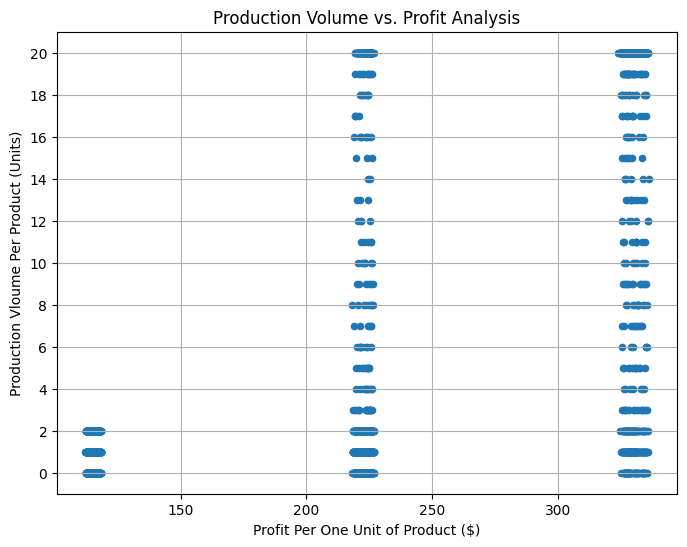

In [15]:
results_profit_df.plot(x="ProfitPerOneUnitProduct", y="ProductionVolume", kind="scatter",
                      xlabel="Profit Per One Unit of Product ($)", ylabel="Production Vloume Per Product (Units)",
                      yticks=np.arange(0, results_profit_df['ProductionVolume'].max()+0.5, 2, dtype=int),
                      title="Production Volume vs. Profit Analysis",
                      grid=True, figsize=(8,6))

In [16]:
sql = f"""
        WITH 
        t1 AS (SELECT
                temp1.ProductionSiteID,
                temp1.MachineID,
                ((temp1.ProductMachineLaborTimeInMin / 60.0) * temp2.ProductionVolume) AS OperationTimePerProduct
            FROM ProductMachineData AS temp1
            INNER JOIN {results_table_name} AS temp2
                ON temp1.ProductionSiteID = temp2.ProductionSiteID
                AND temp1.ProductID = temp2.ProductID),
        t2 AS (SELECT
                ProductionSiteID,
                MachineID,
                SUM(OperationTimePerProduct) AS WeeklyOperationTimeInHour
            FROM t1
            GROUP BY 1, 2)

        SELECT
            t2.ProductionSiteID,
            t2.MachineID,
            t2.WeeklyOperationTimeInHour,
            t3.MachineWeeklyAvailableTimeInHour AS WeeklyAvailableTimeInHour,
            100 * (t2.WeeklyOperationTimeInHour / t3.MachineWeeklyAvailableTimeInHour) AS OperationRatioPercentage
        FROM t2 
        INNER JOIN MachineData AS t3
            ON t2.ProductionSiteID = t3.ProductionSiteID
            AND t2.MachineID = t3.MachineID
        WHERE t3.MachineWeeklyAvailableTimeInHour <> 0
            AND t3.MachineWeeklyAvailableTimeInHour IS NOT NULL
        ;
"""
results_operation_df = pd.read_sql(con=con, sql=sql)
results_operation_df.head()

,ProductionSiteID,MachineID,WeeklyOperationTimeInHour,WeeklyAvailableTimeInHour,OperationRatioPercentage
0,S001,Machine1,120.966667,121.0,99.972452
1,S001,Machine2,104.000000,104.0,100.000000
2,S001,Machine3,81.383333,82.0,99.247967
3,S002,Machine1,121.983333,122.0,99.986339
4,S002,Machine2,100.000000,100.0,100.000000


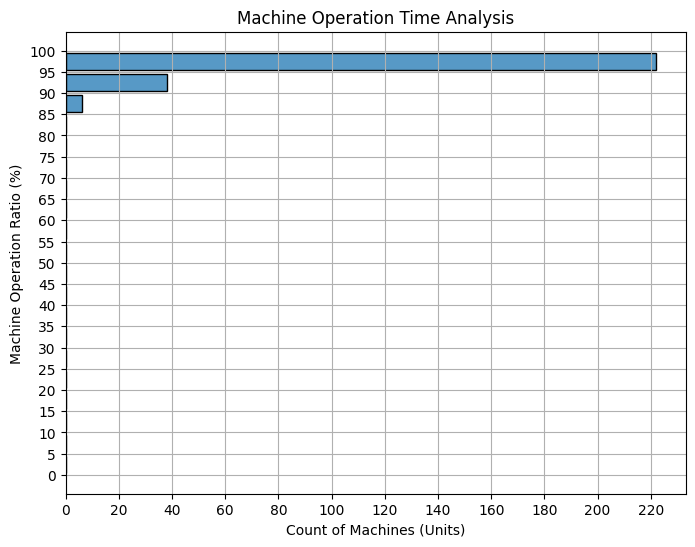

In [17]:
plt.figure(figsize=(8, 6))
ax = sns.histplot(data=results_operation_df, y='OperationRatioPercentage', binrange=(0, 100), shrink=0.8, binwidth=5)
plt.title('Machine Operation Time Analysis')
plt.xlabel('Count of Machines (Units)')
plt.xticks(np.arange(ax.get_xlim()[0], ax.get_xlim()[1]+0.5, 20, dtype=int))
plt.ylabel('Machine Operation Ratio (%)')
plt.yticks(np.arange(0, 101, 5, dtype=int))
plt.grid(True)
plt.show()

## Cleanup

In [18]:
# Clean up database by remove existed tables to prevent error next run
sql = f"""
SELECT name FROM sqlite_master WHERE type='table';
"""
existed_table_list =[table[0] for table in (pd.read_sql_query(con=con, sql=sql)).values]
for table_name in existed_table_list:
    try: 
        execute_sql(con=con, sql=f"DROP TABLE {table_name};")
    except Exception as e:
        print(e)
    print(f"Droped Table: {table_name}")

Droped Table: ProductData
Droped Table: ProductMachineData
Droped Table: MachineData
Droped Table: InventoryData
Droped Table: ProductPlanResults


## Close Connection 

In [19]:
con.close()

# END